In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from collections import Counter
import nltk
from nltk.corpus import stopwords
import wordcloud
import matplotlib.pyplot as plt

# Baixar stopwords (necessário apenas uma vez)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isac.santos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Importar a base de dados CSV com delimitador explícito
df = pd.read_csv('base original.csv', delimiter=';')
df = pd.DataFrame(df)
df['texto'] = df[['title', 'subtitle','text_news']].astype(str).agg(' '.join, axis=1)
df = df[['texto','rating']]
display(df)

texto  \
0      Publicações enganam ao associar Bolsonaro à ap...   
1      Post mostra imagens de outras estradas para af...   
2      Eduardo Bolsonaro posta vídeo antigo sobre lib...   
3      Médica cita estudos não conclusivos para suger...   
4      Médica usa informações falsas em vídeo para fa...   
...                                                  ...   
11642  #Verificamos: É falso que Cristiano Ronaldo va...   
11643  #Verificamos: É falso que Funai ‘reestruturada...   
11644  Um ano após incêndio, promessas para o Museu N...   
11645  #Verificamos: É falso que marcas coloridas na ...   
11646  #Verificamos: É falso que Trump mandou superav...   

                                                  rating  
0                                           ['Enganoso']  
1                                              ['Falso']  
2                                           ['Enganoso']  
3                                           ['Enganoso']  
4                                              ['Falso']  
...                                                  ...  
11642                                          ['FALSO']  
11643                                          ['FALSO']  
11644  ['FALSO', 'VERDADEIRO, MAS', 'EXAGERADO', 'VER...  
11645                                          ['FALSO']  
11646                                          ['FALSO']  

[11647 rows x 2 columns]

In [5]:
import re

# Listas de fake news e real news atualizadas com sinônimos
fake_news = [
    "enganoso", "falso", "contexto errado", "falso", "fake", 
    "fora de contexto", "impreciso", "distorcido", "contraditório", 
    "insustentável", "subestimado", "exagerado", "ainda é cedo para dizer", 
    "não é bem assim", "fake", "enganoso", "contexto errado", "desinformado", 
    "injustificado", "sensacionalista", "pseudociência", "sem provas", 
    "sem fundamento", "sem base científica", "muito improvável", "especulação", 
    "rumor", "boato", "meia-verdade", "não confirmado", "não verificado", 
    "não confiável", "sem evidência", "confusão", "impreciso", "dúvido", 
    "equivocado", "mentiroso", "desmentido", "falta de provas", "perigosamente falso", 
    "mito", "distúrbio", "falsificação", "manipulado", "alterado", "ilusório", 
    "fabricado", "distorcido", "engano", "perigoso", "tendencioso", "escondido", 
    "manipulado", "inverídico", "sem validade", "exagero", "alterado", "hipérbole", 
    "não comprovado", "sem verificação", "incorreto", "teoria da conspiração", 
    "improvável", "vago", "arbitrário", "manipulação", "mentira", "ficção", 
    "especulação infundada", "ilusões", "rumores", "história inventada", 
    "declaração errada", "confusão de fatos", "história distorcida", "relato fictício", 
    "falácia", "versão distorcida", "sem evidências reais", "dúvida infundada", 
    "inverdade", "sem credibilidade", "informação tendenciosa", "criação de pânico",
    # Sinônimos de "Fake"
    "errôneo", "falacioso", "desinformação", "falsificado", "fabricado", "distorcido", "mentiroso"
]

real_news = [
    "comprovado", "evidência comprovada", "fato", "verdadeiro", 
    "factual", "confirmado", "verdadeiro, mas", "concluído", "comprovado", "exato",
    "verdadeiro, porém", "verdade", "verdadeiro, mas", "verdadeiro, contudo", 
    "verdadeiro, no entanto", "verdadeiro, entretanto", "verdadeiro, todavia", 
    "verificado", "conforme os fatos", "com base em dados", "em evidência", 
    "comprovação", "acreditado", "confirmado cientificamente", "demonstração", 
    "corroborado", "suportado por provas", "validado", "conformidade", 
    "autêntico", "realmente", "comprovadamente", "com respaldo", "embasado", 
    "preciso", "fundamentado", "insustentável", "comprovado por fontes", 
    "detalhado", "dado científico", "acertado", "precisão", "fidedigno", "baseado em fatos", 
    "documentado", "sem dúvida", "sem contestação", "irrefutável", "baseado em evidências", 
    "confirmado através de provas", "indiscutível", "de acordo com", "correto", "inequívoco", 
    "definitivo", "aprovado", "autêntica evidência", "baseado em pesquisa", 
    "em conformidade", "seguro", "irrefutável", "sem questionamento", "atestados", 
    "aprovado cientificamente", "confirmado com clareza", "inequivocamente",
    # Sinônimos de "Real"
    "autêntico", "legítimo", "válido", "fundamentado", "suportado", "confirmado cientificamente", 
    "confiável", "verdadeiro, mas", "conforme dados", "comprovação", "preciso", "fidedigno", 
    "embasado", "corroborado", "sem contestação", "irrefutável"
]

# Função para limpar pontuação e deixar as palavras em minúsculas
def limpar_texto(texto):
    # Remove pontuações e converte para minúsculas
    texto = re.sub(r'[^\w\s]', '', texto.lower())  # Remove pontuação
    return texto

# Função para classificar cada linha
def classificar_linha(valor):
    # Limpa o texto da linha antes de verificar as palavras-chave
    valor_limpo = limpar_texto(valor)
    
    # Conta quantas palavras da fake_news e real_news estão no texto limpo
    fake_count = sum(1 for word in fake_news if word in valor_limpo)
    real_count = sum(1 for word in real_news if word in valor_limpo)
    
    # Classificação com base nas contagens
    if fake_count >= real_count:
        return 1
    elif real_count > fake_count:
        return 0
    else:
        return 'Unknown'

# Aplica a função para classificar cada valor
df['rating'] = df['rating'].str.lower()  # Garantir que o texto esteja em minúsculas
df['rating'] = df['rating'].str[2:-2]  # Remove os dois primeiros e últimos caracteres
df['classification'] = df['rating'].apply(classificar_linha)

# Contabiliza a quantidade de cada categoria
fake, real, unk = 0, 0, 0
for valor in df['classification']:
    if valor == 1:
        fake += 1
    elif valor == 0:
        real += 1
    else:
        unk += 1

# Exibe as contagens
print(f'Fake: {fake}')
print(f'Real: {real}')
print(f'Unknown: {unk}')

df = df.drop(columns=['rating'])
display(df)

Fake: 11336
Real: 311
Unknown: 0


texto  classification
0      Publicações enganam ao associar Bolsonaro à ap...               1
1      Post mostra imagens de outras estradas para af...               1
2      Eduardo Bolsonaro posta vídeo antigo sobre lib...               1
3      Médica cita estudos não conclusivos para suger...               1
4      Médica usa informações falsas em vídeo para fa...               1
...                                                  ...             ...
11642  #Verificamos: É falso que Cristiano Ronaldo va...               1
11643  #Verificamos: É falso que Funai ‘reestruturada...               1
11644  Um ano após incêndio, promessas para o Museu N...               1
11645  #Verificamos: É falso que marcas coloridas na ...               1
11646  #Verificamos: É falso que Trump mandou superav...               1

[11647 rows x 2 columns]

In [6]:
# Filtra as linhas onde a classificação é 1 (Fake)
fake_df = df[df['classification'] == 1]
real_df = df[df['classification'] == 0]

# Verifica se há linhas suficientes para o sorteio
if len(fake_df) >= 311:
	# Sorteia 311 linhas aleatórias entre as linhas Fake
	fake_sample = fake_df.sample(n=311, random_state=42)  # random_state é opcional, mas ajuda a obter o mesmo resultado em execuções subsequentes

	# Exibe o DataFrame com as linhas sorteadas
else:
	print("Não há linhas suficientes para o sorteio.")
	

fake_df = fake_df.sample(n=311, random_state=42)  # random_state é opcional, mas ajuda a obter o mesmo resultado em execuções subsequentes
df_geral = pd.concat([fake_df, real_df]).sample(frac=1).reset_index(drop=True)

print(len(fake_df))
print(len(real_df))
print(len(df_geral))

311
311
622


In [103]:
def extrair_topicos(df, coluna_texto, n_topicos, max_words=10):

    vetorizador = TfidfVectorizer(stop_words=stopwords.words('portuguese'), max_features=1000000)
    vetorizador.fit(df[coluna_texto])
    vetorizado = vetorizador.transform(df[coluna_texto])
    matriz = vetorizado.toarray()
    #print(matriz)


   
    nmf = NMF(n_components=n_topicos, random_state=42)
    W = nmf.fit_transform(vetorizado) 
    H = nmf.components_
    #print(W)
    #print(H)

    feature_names = vetorizador.get_feature_names_out()

    for topic_idx, topic in enumerate(H):
        #num_palavras = 10  # Quantidade de palavras a serem mostradas de cada tópico
        print(f"\nTópico {topic_idx+1}: ", " | ".join([feature_names[i] for i in topic.argsort()[-max_words:]]))
        
        # Criar um dicionário de palavras e seus pesos
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()}
        
        # Gerar a nuvem de palavras com um máximo de 100 palavras = max_words
        wc = wordcloud.WordCloud(width=500, height=300, background_color="white", max_words=max_words).generate_from_frequencies(word_freq)
        
        # Exibir a nuvem de palavras
        plt.figure(figsize=(8, 4))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nuvem de Palavras - Tópico {topic_idx}")
        plt.show()



Tópico 1:  dia | governador | guilherme | estado | covas | municipal | prefeito | ano | milhões | rio | bilhões | prefeitura | candidato | boulos | paulo


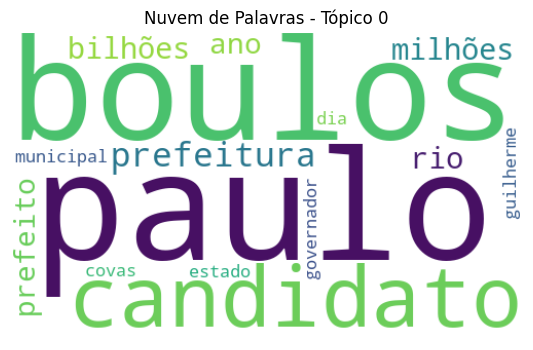


Tópico 2:  eficácia | estudos | pacientes | medicamento | coronavírus | estudo | oms | hidroxicloroquina | cloroquina | saúde | ivermectina | uso | tratamento | 19 | covid


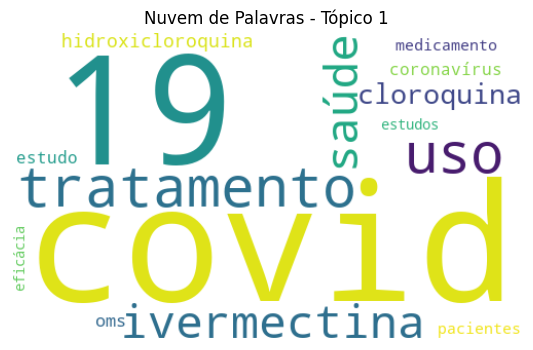


Tópico 3:  compartilhar | org | dando | grátis | luiza | magazine | mensagem | link | boatos | promoção | boato | história | internet | whatsapp | site


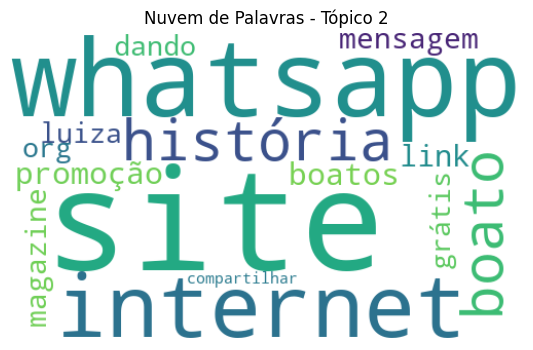


Tópico 4:  pf | federal | história | papa | silva | vaticano | cut | penitenciária | moro | jato | lava | prisão | presidente | ex | lula


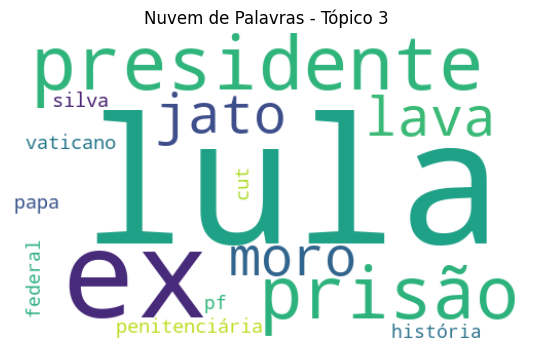


Tópico 5:  checagens | identificar | trump | falsaveja | equipe | diz | feitas | vídeos | mensagem | bahia | homem | mostra | fake | imagens | vídeo


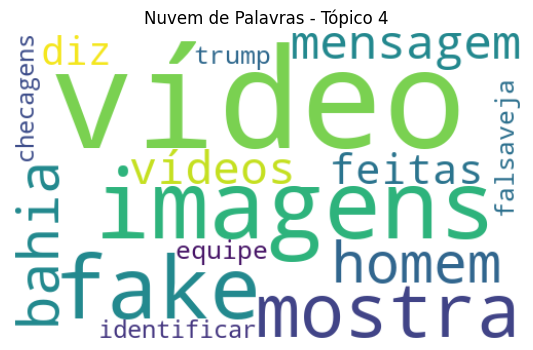


Tópico 6:  verifica | legenda | mortes | postagens | 2020 | facebook | maju | estadão | lupa | verificação | transparência | registro | 2019 | imagem | foto


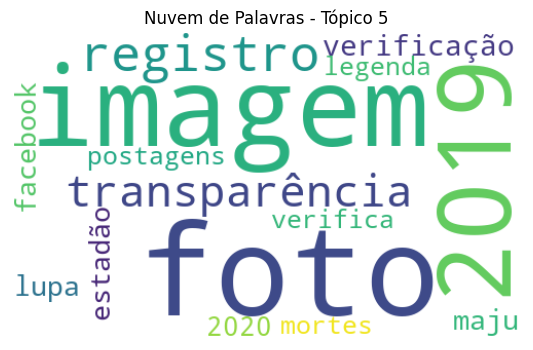


Tópico 7:  urnas | rodrigo | santoro | sobre | exército | moro | globo | contra | entrevista | ministro | governo | programa | jair | presidente | bolsonaro


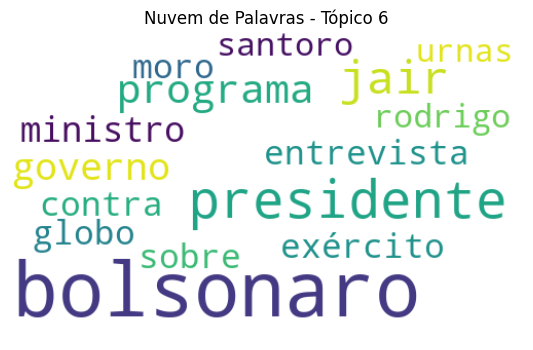


Tópico 8:  doses | governo | vacinas | astrazeneca | contra | células | chinês | testes | imunização | 19 | covid | sinovac | coronavac | china | vacina


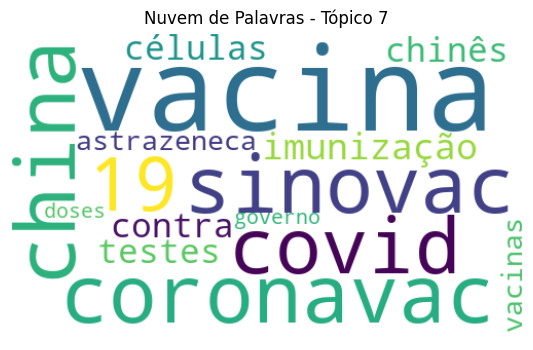


Tópico 9:  sal | desperdiçada | saúde | consumo | privatizar | garganta | coco | cedae | zika | coronavírus | quente | nestlé | vírus | bebedouro | água


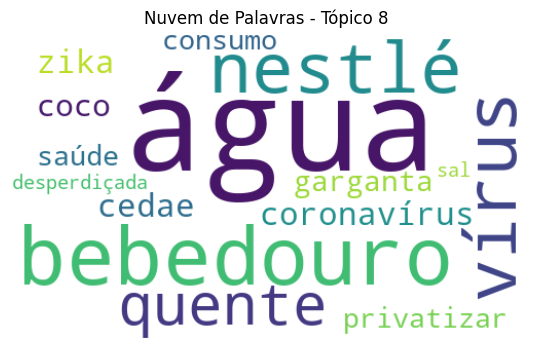


Tópico 10:  mil | cultura | autorizados | culturais | milhão | minc | turnê | recursos | autorizada | projeto | lei | milhões | projetos | rouanet | captar


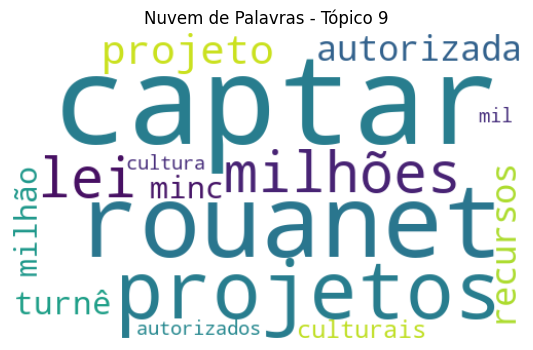

In [82]:
extrair_topicos(fake_df, coluna_texto= "texto", n_topicos=10, max_words=15)

In [85]:
# Importar a base de dados CSV com delimitador explícito
dfblibia = pd.read_csv('biblia.csv', delimiter=';')
dfblibia = pd.DataFrame(dfblibia)

# Verificar os nomes das colunas
print(dfblibia.columns)

# Dividir a coluna única em múltiplas colunas
dfblibia[['versao', 'testamento', 'posicao', 'livro', 'capitulo', 'versiculo', 'texto']] = dfblibia['versao,testamento,posicao,livro,capitulo,versiculo,texto'].str.split(',', expand=True, n=6)

# Selecionar as colunas desejadas
dfblibia = dfblibia[['livro', 'capitulo', 'versiculo', 'texto']]

display(dfblibia)

df2=dfblibia[dfblibia['livro'] == 'Apocalipse']

Index(['versao,testamento,posicao,livro,capitulo,versiculo,texto'], dtype='object')


livro capitulo versiculo  \
0         Genesis        1         1   
1         Genesis        1         2   
2         Genesis        1         3   
3         Genesis        1         4   
4         Genesis        1         5   
...           ...      ...       ...   
181236  Malaquias        4         2   
181237  Malaquias        4         3   
181238  Malaquias        4         4   
181239  Malaquias        4         5   
181240  Malaquias        4         6   

                                                    texto  
0              No princípio criou Deus os céus e a terra.  
1                         E a terra era sem forma e vazia  
2                                  E disse Deus: Haja luz  
3                            E viu Deus que era boa a luz  
4                                 E Deus chamou à luz Dia  
...                                                   ...  
181236  "Mas para vós, os que temeis o meu nome, nasce...  
181237  "Pisareis os ímpios, pois serão cinza debaixo ...  
181238  "Lembrai-vos da lei de Moisés, meu servo, a qu...  
181239  "Eis que eu vos enviarei o profeta Elias, ante...  
181240  "Ele converterá o coração dos pais aos filhos,...  

[181241 rows x 4 columns]


Tópico 1:  debaixo | meteu | levantou | foice | nuvem | aberto | reis | mão | vi | habitam | pé | céu | mar | sobre | terra


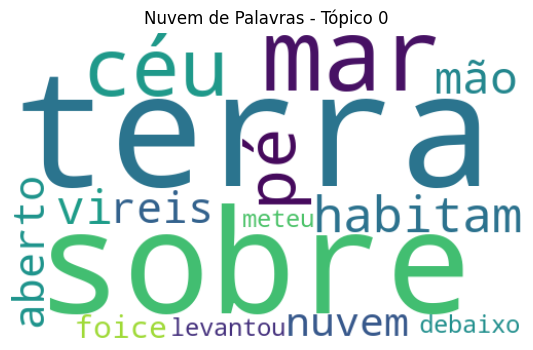


Tópico 2:  vencedor | morte | árvore | segunda | sofrerá | paraíso | comer | darei | alguém | vencer | diz | espírito | igrejas | ouvidos | ouça


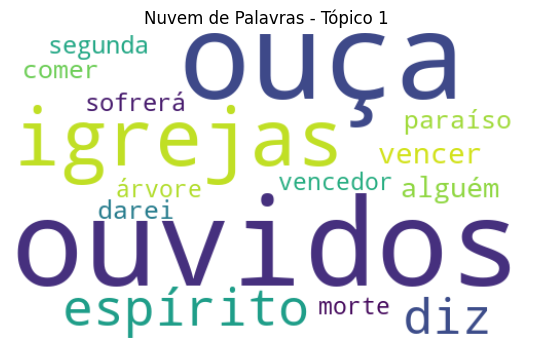


Tópico 3:  igrejas | ira | últimas | vi | espíritos | cabeças | candeeiros | pragas | ouro | trombetas | taças | destra | estrelas | anjos | sete


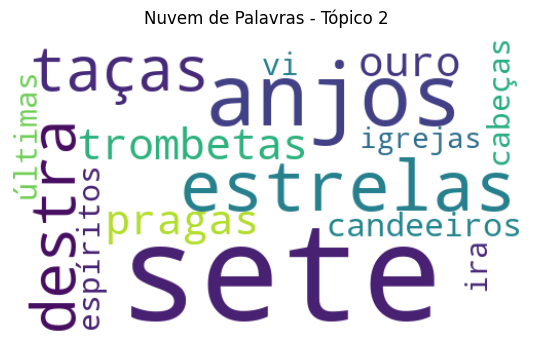


Tópico 4:  rei | cântico | juízos | alfa | vir | és | justos | verdadeiros | santuário | cordeiro | porque | deus | poderoso | todo | senhor


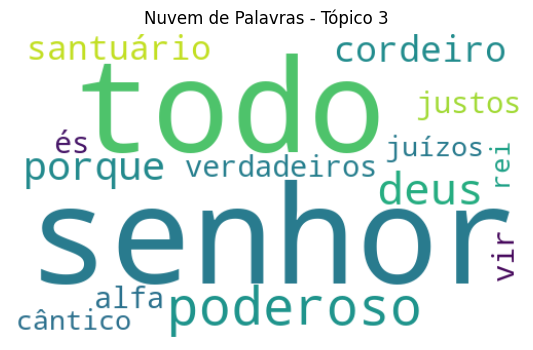


Tópico 5:  assentados | anjos | deus | rostos | amém | tronos | redor | diante | adoraram | seres | vinte | prostraram | viventes | anciãos | quatro


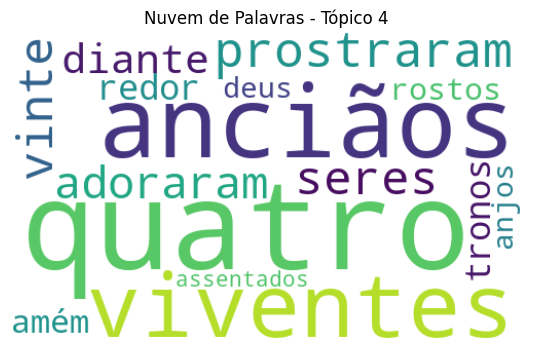


Tópico 6:  havia | tribos | muro | zebulom | israel | anos | judá | nomes | aser | simeão | portas | assinalados | tribo | mil | doze


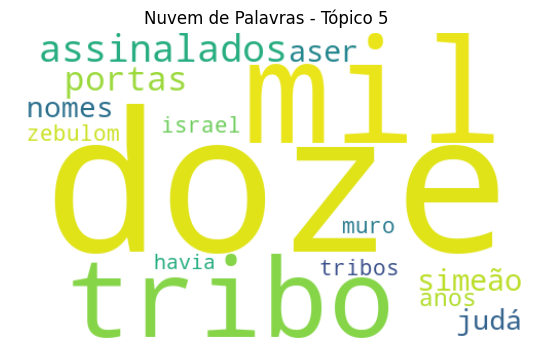


Tópico 7:  ferida | nome | receberam | número | subir | sinal | viste | adoraram | vi | autoridade | cabeças | chifres | imagem | dez | besta


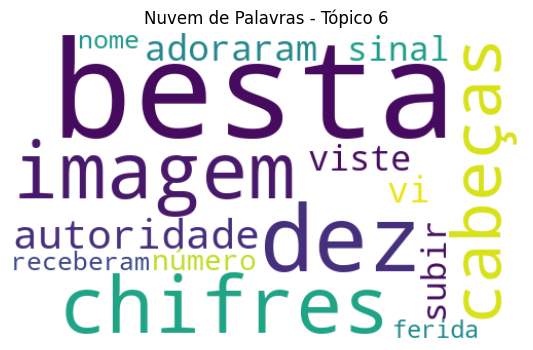


Tópico 8:  chave | foice | mão | saiu | grande | tocou | escreve | trombeta | igreja | derramou | taça | céu | vi | outro | anjo


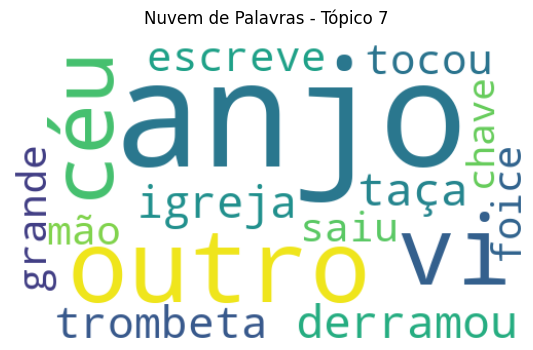


Tópico 9:  coisa | verdadeiras | escritas | neste | venho | vida | alguém | aventurado | abrir | bem | deste | disse | profecia | palavras | livro


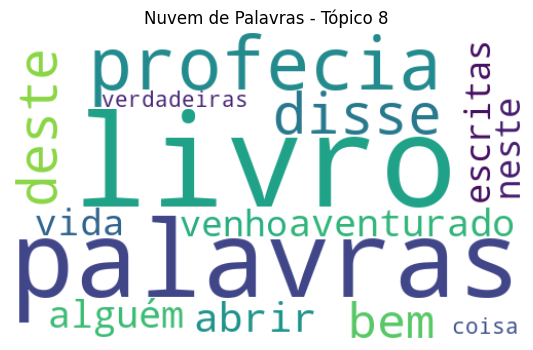


Tópico 10:  poder | trovões | aleluia | deus | multidão | trovão | salvação | dizendo | águas | muitas | céu | dizia | grande | ouvi | voz


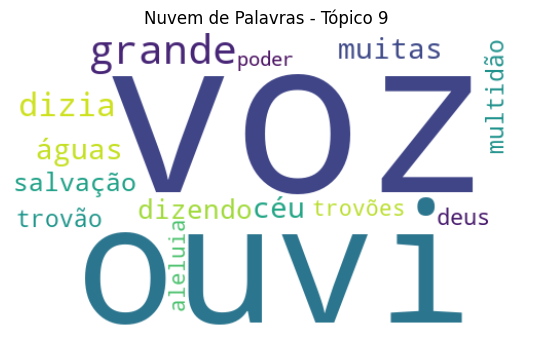


Tópico 11:  fino | jaspe | púrpura | pérolas | puro | linho | portas | preciosas | pedras | muro | semelhante | ouro | grande | ai | cidade


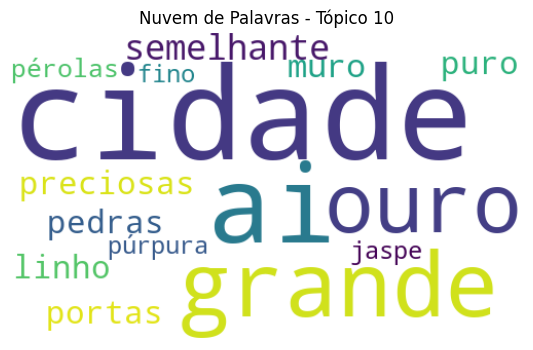


Tópico 12:  guardam | viu | tabernáculo | abriu | testificou | mandamentos | reino | tudo | céu | cristo | causa | palavra | testemunho | jesus | deus


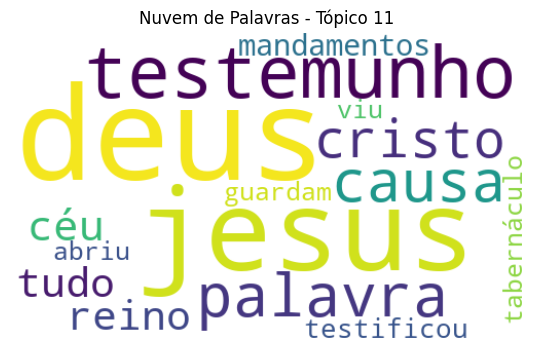


Tópico 13:  deus | clamavam | eis | imediatamente | posto | destra | arrebatado | semelhante | daquele | cristal | cordeiro | sobre | diante | assentado | trono


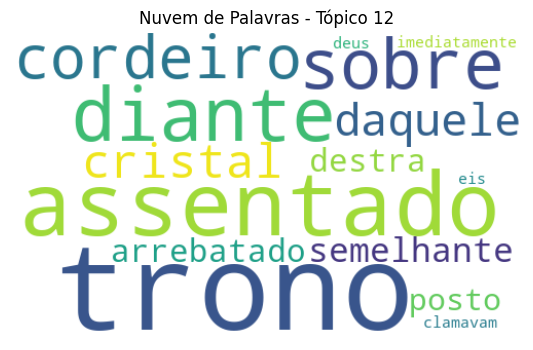


Tópico 14:  saíam | dia | mar | segunda | lançado | trombeta | lançados | tocou | homens | enxofre | morte | lago | fogo | terça | parte


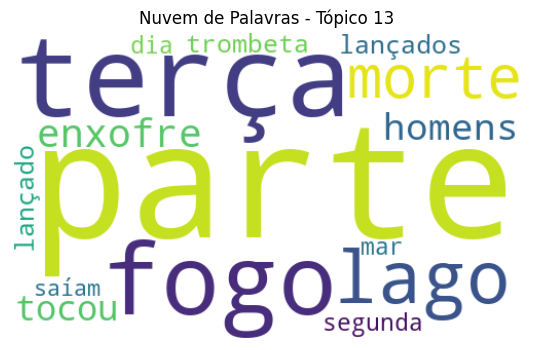


Tópico 15:  venho | quarto | branco | montado | terceiro | ouvi | dizer | vivente | segundo | olhei | selo | cavalo | vem | abriu | eis


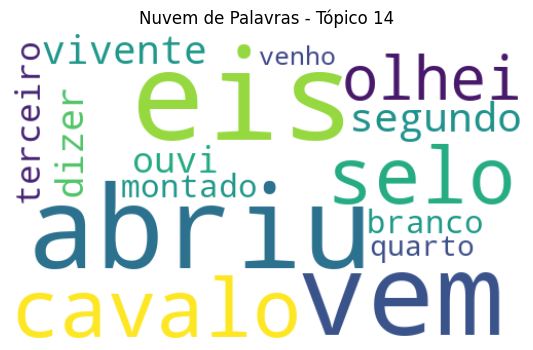


Tópico 16:  deus | domínio | sempre | receber | força | sabedoria | vive | louvor | ações | graças | amém | poder | honra | glória | séculos


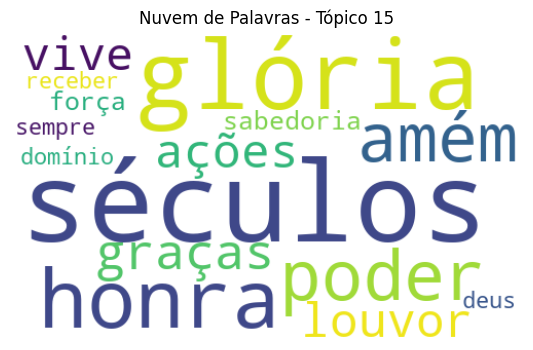


Tópico 17:  falso | profeta | pés | fazer | imundos | rãs | blasfêmias | mulher | semelhantes | serpente | saía | contra | espada | dragão | boca


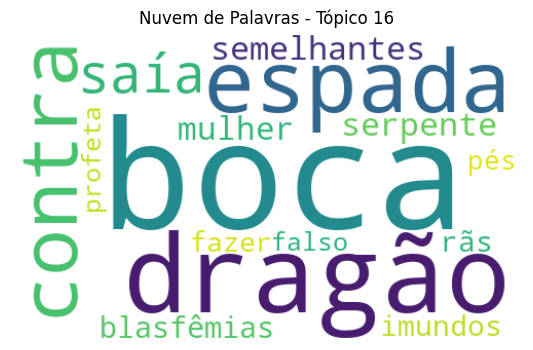


Tópico 18:  deu | filho | andarão | caiu | prostituíram | prostituição | línguas | povos | trarão | ira | vinho | luz | todas | reis | nações


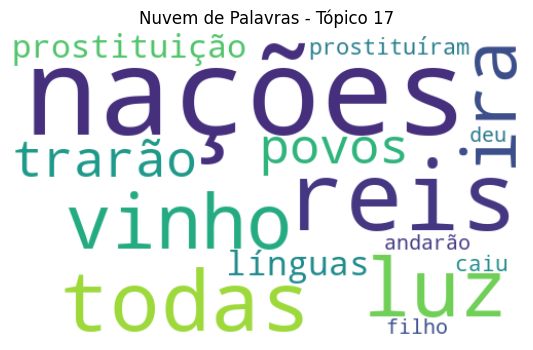


Tópico 19:  arrepende | primeiras | porém | pois | perseverança | sei | amor | quente | frio | ti | tens | nome | és | conheço | obras


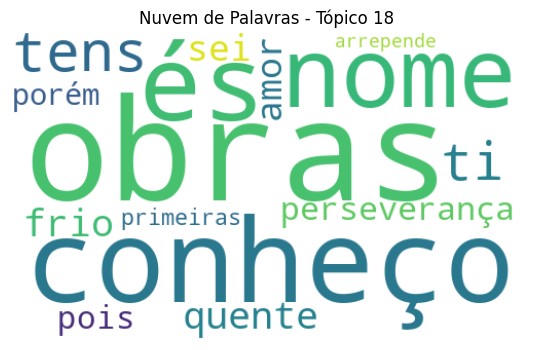


Tópico 20:  merecem | admiração | mar | cordeiro | embriagada | dado | beber | achou | derramaram | nela | todos | mortos | profetas | santos | sangue


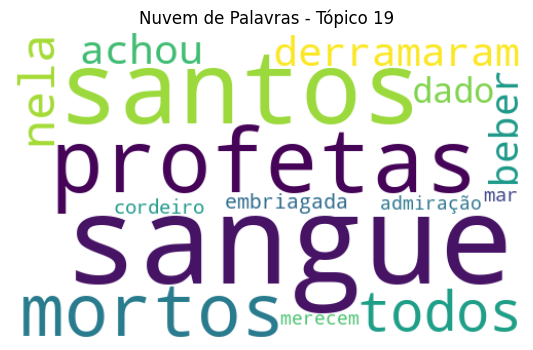

In [110]:
extrair_topicos(df2, coluna_texto= "texto", n_topicos=20, max_words=15)

In [65]:
# Importar a base de dados CSV com delimitador explícito
dfharry = pd.read_csv('harry.csv', delimiter=';')
dfharry = pd.DataFrame(dfharry)

# Verificar os nomes das colunas
print(dfharry.columns)

# Dividir a coluna única em múltiplas colunas
dfharry[['capitulo', 'paragrafo', 'texto']] = dfharry['capitulo,paragrafo,texto'].str.split(',', expand=True, n=2)
dfharry = dfharry[['capitulo', 'paragrafo', 'texto']]
dfharry = dfharry.iloc[70:]

#df3=dfharry[dfharry['capitulo'] == '1']

display(dfharry)



Index(['capitulo,paragrafo,texto'], dtype='object')


capitulo paragrafo                                              texto
70          1         2                            O Menino Que Sobreviveu
71          1         3  "O Sr. e a Sra. Dursley, da Rua dos Alfeneiros...
72          1         4  "O Sr. Dursley era Diretor de uma firma chamad...
73          1         5  "Os Dursley tinham tudo que queriam, mas tinha...
74          1         6  "A Sra. Potter era irmã da Sra. Dursley, mas n...
...       ...       ...                                                ...
3385       17       237  "— Espero que você tenha... Há... Umas boas fé...
3386       17       238  "— Ah, claro que sim — respondeu Harry, e eles...
3387       17       239                                                   
3388       17       240                                                   
3389       17       241                                                FIM

[3320 rows x 3 columns]


Tópico 1:  levantou | mão | virou | porta | olhou | fazer | viu | olhos | cabeça | harry


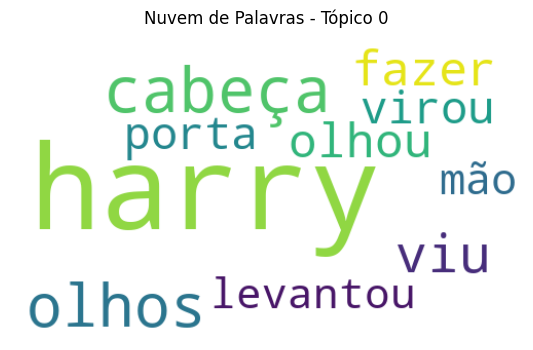


Tópico 2:  boca | aqui | tarde | boa | bom | dumbledore | acho | voz | ah | disse


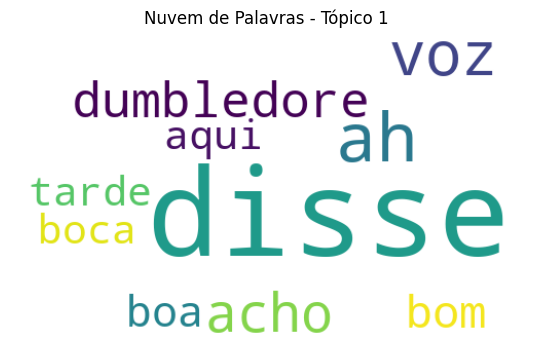


Tópico 3:  virou | cochichou | ficou | tão | resmungou | cara | lado | weasley | draco | rony


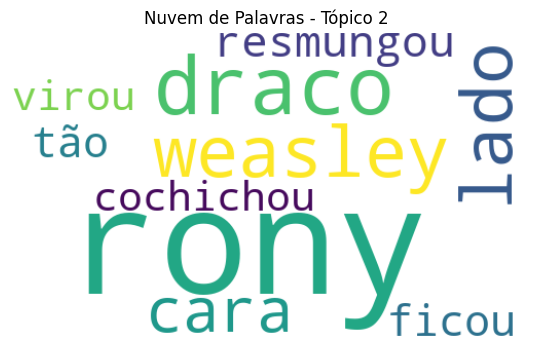


Tópico 4:  sra | olivaras | weasley | verdade | falou | prezado | aí | dursley | sr | potter


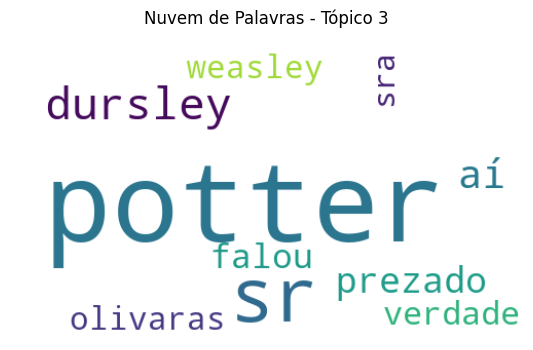


Tópico 5:  rúbeo | vendo | agora | voz | aconteceu | então | onde | ansioso | percy | perguntou


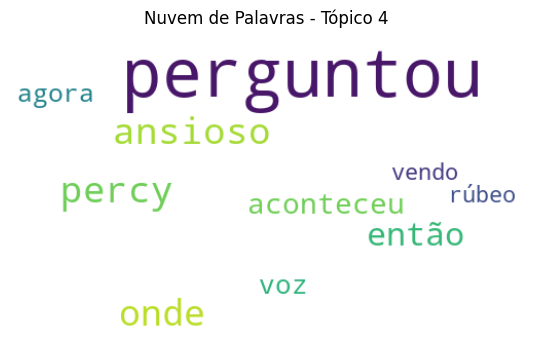


Tópico 6:  murmurou | perguntar | ter | qualquer | sabia | viu | comer | ronan | alguma | coisa


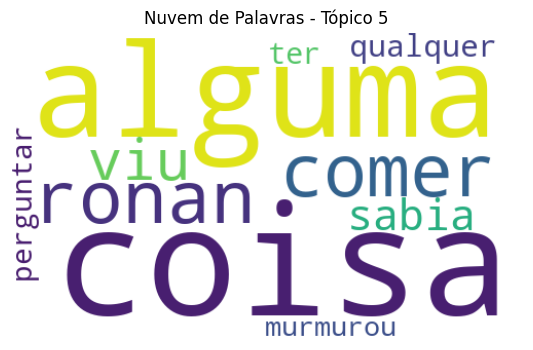


Tópico 7:  hogwarts | malfoy | grande | cara | sempre | então | parecia | resmungou | sorriu | hagrid


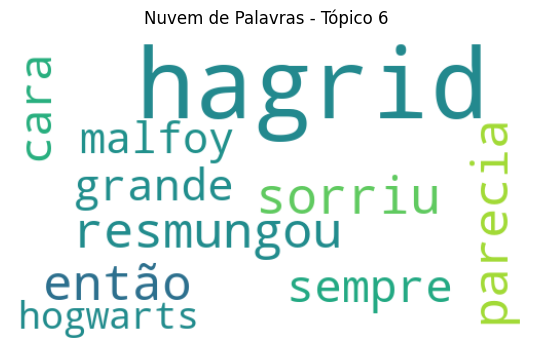


Tópico 8:  escola | voltar | vou | ficar | embora | hoje | noite | falou | hogwarts | vai


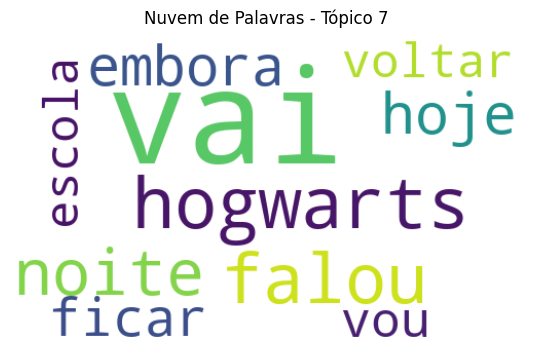


Tópico 9:  carro | gritou | dursley | cozinha | carta | petúnia | tia | duda | tio | válter


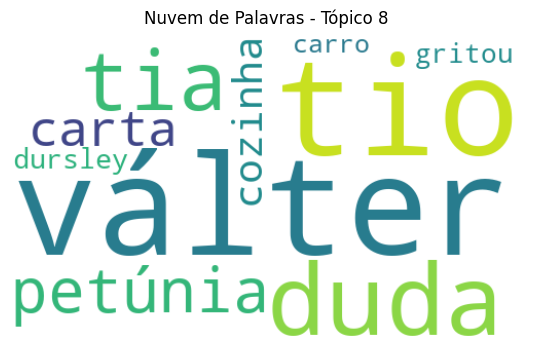


Tópico 10:  cofre | treze | setecentos | indagou | onde | tudo | ansioso | plataforma | ofegou | quê


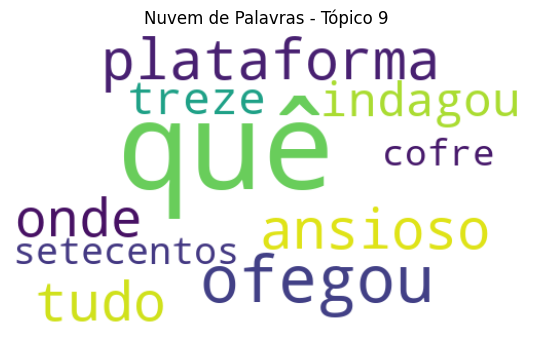


Tópico 11:  alunos | favor | senhora | professor | mcgonagall | mcconagall | cabeça | dumbledore | minerva | professora


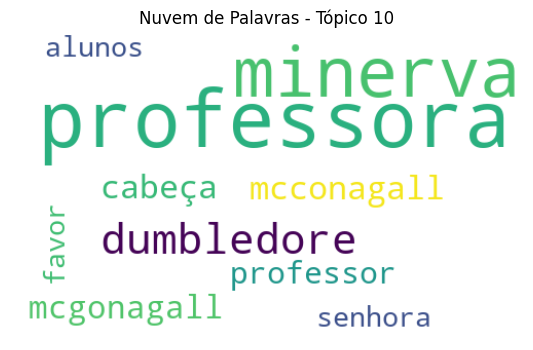


Tópico 12:  primeiro | falou | sussurrou | mão | voltou | deu | dois | neville | granger | hermione


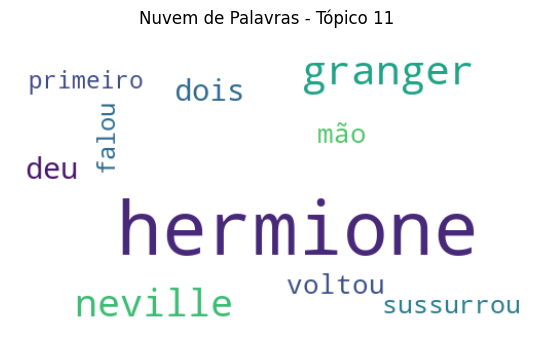


Tópico 13:  sabia | quer | tentando | falar | tempo | lo | pedra | professor | quirrell | snape


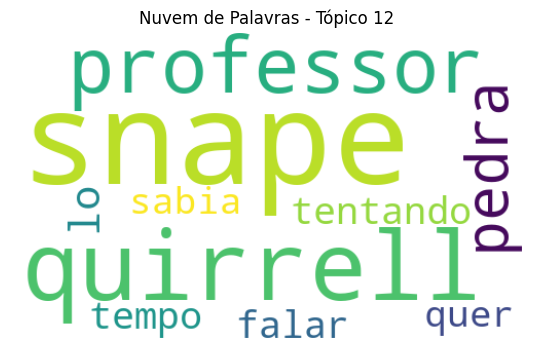


Tópico 14:  venham | sussurrou | comigo | ter | melhor | vou | então | agora | fazer | vamos


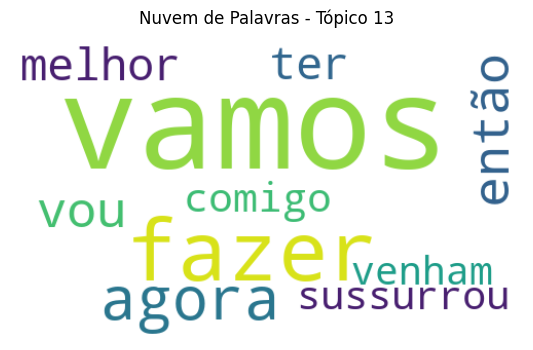


Tópico 15:  exclamou | soube | chave | professor | pode | sim | vi | então | sei | senhor


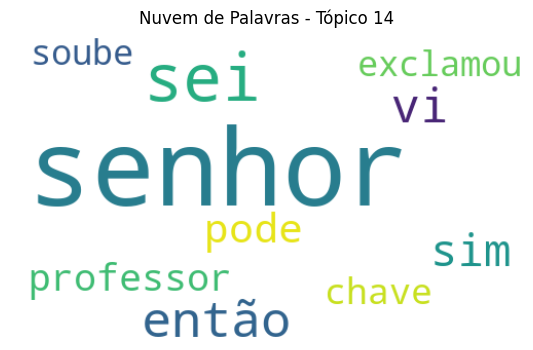


Tópico 16:  primeiro | ah | obrigado | ano | vindo | hum | favor | use | tudo | bem


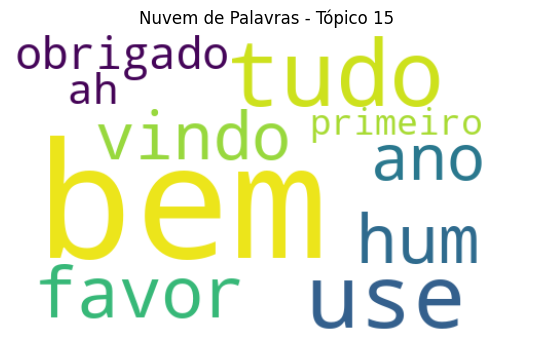


Tópico 17:  vol | todo | mundo | sonserina | casa | quero | lufa | dizer | aqui | sabe


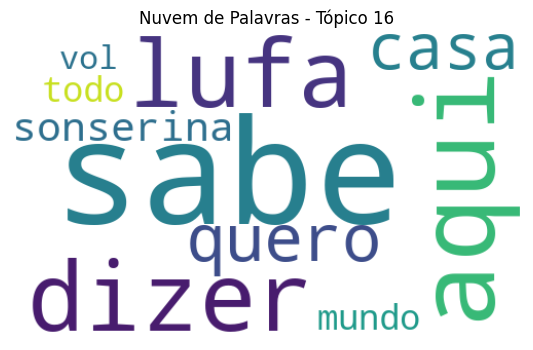


Tópico 18:  voando | acho | seca | hum | ainda | quase | sei | ninguém | ah | respondeu


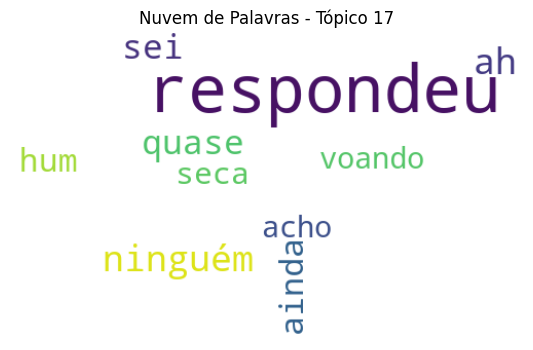


Tópico 19:  havia | consigo | dizer | ver | tão | quero | cabeça | dursley | nunca | nada


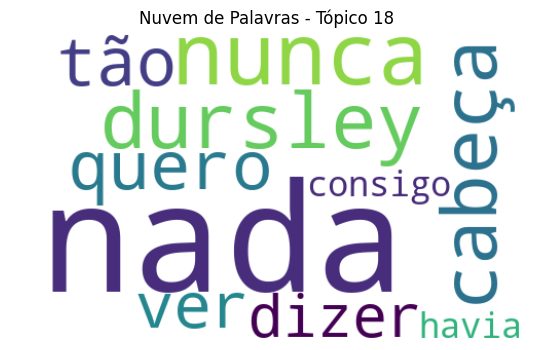


Tópico 20:  sair | primeiro | volta | bateu | então | desta | dumbledore | porta | outra | vez


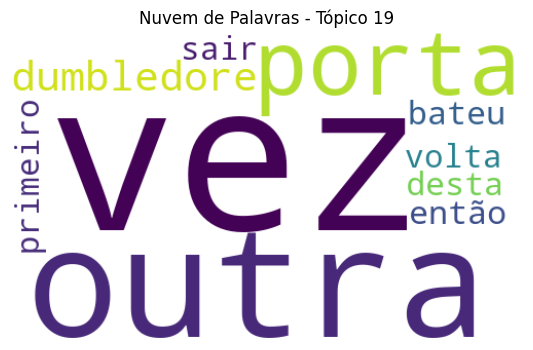

In [76]:
extrair_topicos(dfharry, coluna_texto= "texto", n_topicos=20, max_words=10)